In [1]:
from numpy.typing import ArrayLike
from scipy.integrate import solve_ivp
import make_plot
import numpy as np

In [2]:
def get_init_conds(avg_tumor_size:float=15e-6, num_tumor_cells:float|int=10e8, 
                   nk_area_ratio:float=1/50, nk_to_cd8:float=1/4,
                   max_tumor_size:float=150) -> np.array:
    """This function computes an estimate of the number of NK and CD8+ cell
    present at a tumor site. It returns an array meant to be the starting
    conditions for the cancer growth model.
    
    Parameters:
        - avg_tumor_size (float): the average diameter of a tumor cell in
                                  meters. Defaulted to 15e-6 (i.e. 15 
                                  microns).
        - num_tumor_cells (float|int): the number of tumor cells 
        - nk_area_ratio (float): the ratio of 1 NK cell per x-amount of
                                 millimeter-squared of tumor (i.e. the 
                                 inverse of millimeter-squared of tumor 
                                 area per 1 NK cell). Defaulted to 1/50 
                                 which signifies that there is 1 NK cell 
                                 per 50 mm^2 of tumor area.
        - nk_to_cb8 (float): the ratio of NK cells to CB8+ cells found in
                             the body of a person. Defaulted to an average
                             ratio of 1 NK cell to 4 (i.e. 1/4)
                         
    Returns:
        - ((3, ); np.array): the starting conditions for modeling
                                       and the max tumor size. This is number 
                                       of tumor cells, number of NK cells, and
                                       number of CB8+ cells. 
    """

    tumor_area = (np.pi *(avg_tumor_size/2)**2) * num_tumor_cells
    num_nk_cells = nk_area_ratio * (1000**2) * tumor_area
    num_cd8_cells = 1/nk_to_cd8 * num_nk_cells
    #max_num_cells = (max_tumor_size/1000/2)**3/avg_tumor_size**3

    return np.array([num_tumor_cells, int(num_nk_cells), int(num_cd8_cells)])#, max_num_cells

In [3]:
# define the ODE function
def breast_cancer_ode(t, y, a, T_max, mu, gamma, alpha, d, s, lam, sigma, f, g, h, p, m, j, k, q, r, chemo_times):
    """ Model for breast cancer growth dependent on chemotherapy and 2 different immune system
    cells.

    Parameters:

    
    """
    tol =1
    T, N, L = y
    gompertz = a*T*np.log(T_max / T)
    D = d * ((L/T)**lam)/(s + (L/T)**lam) * T

    # chemo treatment times
    chemo_term = 0
    for day in chemo_times:
        if t >= day:
            t_since_start = t - day
            ct = np.exp(-gamma*(t_since_start))
            chemo_term += mu*ct*T

    eqT = gompertz - chemo_term - alpha*N*T - D
    eqN = sigma - f*N + N*(g*T**2)/(h + T**2) - p*N*T - 0.00005*chemo_term*N
    eqL = -m*L +  L*(j*D**2)/(k+D**2) - q*L*T + r*N*T - 0.00005*chemo_term*L

    if T<tol:
        T = 0
        eqT = 0
    if N < tol:
        N = 0
    if L < tol:
        L = 0
        
    return np.array([eqT, eqN, eqL])

In [4]:
##########
# Choose model parameters
##########
# gompertz parameters
a, T_max = 1/90, 1/(1.023e-9) # growth rate: 1/day, maximum tumor burden: # cells

# chemotherapy parameters
mu, gamma = 0.9, 0.92 # drug sensitivity of cells, decay constant of chemo drug: 1/day (ln(2)/half life of drug)

# parameters for D
d, s, lam = 5.80, 2.5e-1, 1.36 

# parameters for derivative of N, number of killer cells
alpha = 3.23e-7 # name for 'c' the kill rate of untrained killer cells: 1/(cell*day)
sigma, f = 1.3e4, 4.12e-2 # constant source of NK cells: cells/day, death rate of NK cells: 1/day
g = 2.5e-2 # max recruitment rate of NK cells by the tumor: 1/day
h, p = 2.02e7, 1e-7 # steepness of NK recruitment curve: cell**2, NK death rate by cancer cells: 1/(cell*day)

# parameters for derivative of L, the CD8 cells
m, j = 2e-2, 3.75e-2 # death rate of CD8 cells: 1/day, max CD8 recruitment rate: 1/day
k = 2e7 # steepness coefficient of CD8 recruitment curve: cell**2
q = 3.42e-10 # Inactivation rate of CD8 by cancer cells: 1/(cell*day)
r = 1.1e-7  # rate at which NK cells killing cancer cells stimulates CD8 cells

# chemo treatment days
n_treatments = 14
days_between_treatments = 28
start_chemo = 60
chemo_days = np.arange(start_chemo, start_chemo+days_between_treatments*n_treatments, days_between_treatments)


# the time domain and initial guess
n_years = 3.6
t_span = (0.1, 365*n_years) # 1 years
y0 = get_init_conds(num_tumor_cells=9e8) # Tumor burden, Nk cells, CD8 cells

In [5]:
#############
# solve the system
#############
sol = solve_ivp(breast_cancer_ode, t_span, y0, args=[a, T_max, mu, gamma, alpha, d, s, lam, sigma, f, g, h, p, m, j, k, q, r, chemo_days], max_step=0.8)

/var/folders/l8/60hs794140d16gffhvwt3qd40000gn/T/ipykernel_23402/1456465334.py:13: RuntimeWarning: invalid value encountered in scalar power
  D = d * ((L/T)**lam)/(s + (L/T)**lam) * T
/var/folders/l8/60hs794140d16gffhvwt3qd40000gn/T/ipykernel_23402/1456465334.py:12: RuntimeWarning: invalid value encountered in log
  gompertz = a*T*np.log(T_max / T)


In [6]:
time, tumor, NK, CB8 = sol.t, sol.y[0], sol.y[1], sol.y[2]

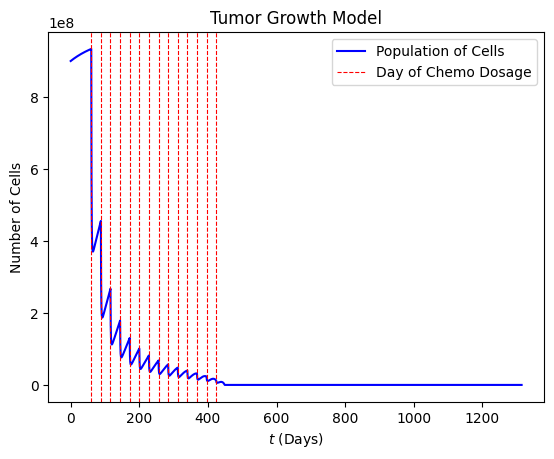

In [13]:
make_plot.plot(t_vals=time, sol_vals=tumor, chemo_days=chemo_days, normal_plot=True, title="Tumor Growth Model", save=True)

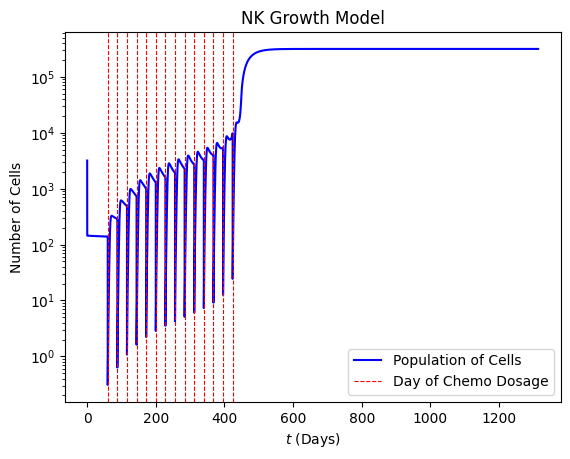

In [14]:
make_plot.plot(t_vals=time, sol_vals=NK, chemo_days=chemo_days, semilogy=True, title="NK Growth Model")

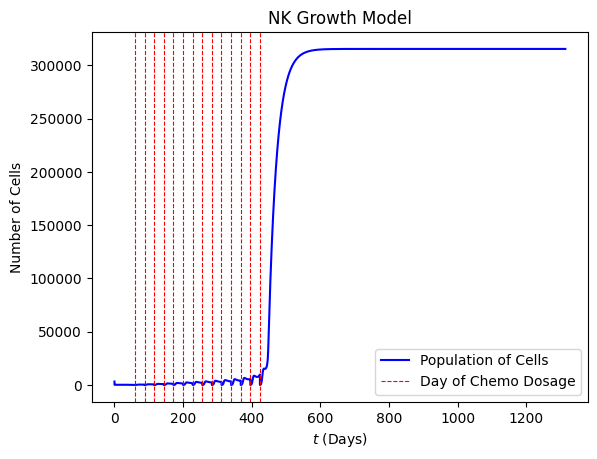

In [10]:
make_plot.plot(t_vals=time, sol_vals=NK, chemo_days=chemo_days, normal_plot=True, title="NK Growth Model")

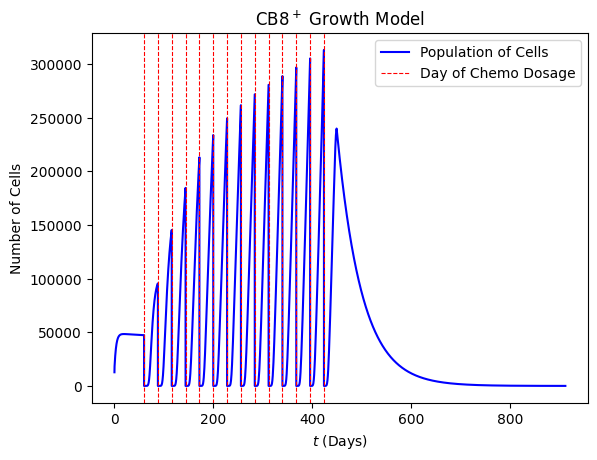

In [10]:
make_plot.plot(t_vals=time, sol_vals=CB8, chemo_days=chemo_days, normal_plot=True, title="CB8$^+$ Growth Model")

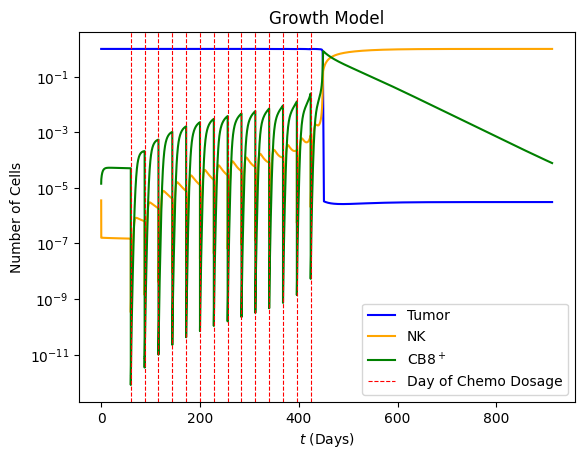

In [13]:
make_plot.plot(chemo_days=chemo_days,semilogy=True, plot_all=True, sol=sol)

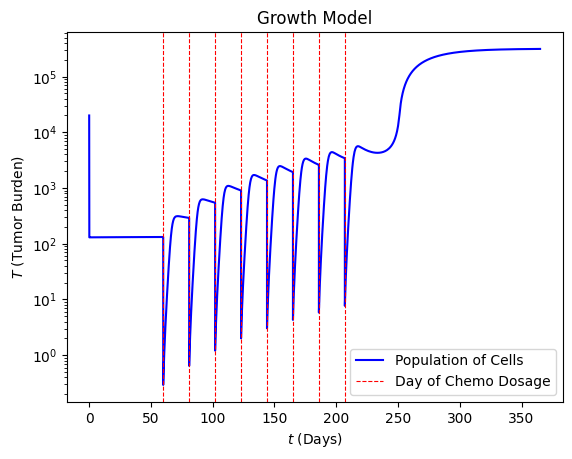

In [16]:
make_plot.plot(t_vals=sol.t, sol_vals=NK, chemo_days=chemo_days, semilogy=True)

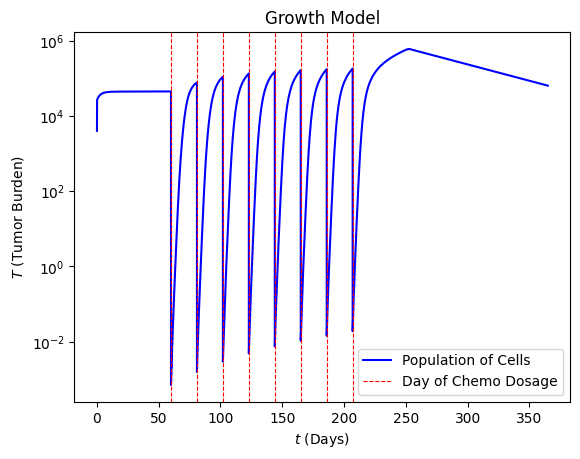

In [17]:
make_plot.plot(t_vals=sol.t, sol_vals=CB8, chemo_days=chemo_days, semilogy=True)

/var/folders/zl/1w6b2xdd3k1djjqk561_wwr40000gr/T/ipykernel_24372/172808170.py:11: RuntimeWarning: invalid value encountered in log
  gompertz = a*T*np.log(T_max / T)
/var/folders/zl/1w6b2xdd3k1djjqk561_wwr40000gr/T/ipykernel_24372/172808170.py:12: RuntimeWarning: invalid value encountered in scalar power
  D = d * ((L/T)**lam)/(s + (L/T)**lam) * T


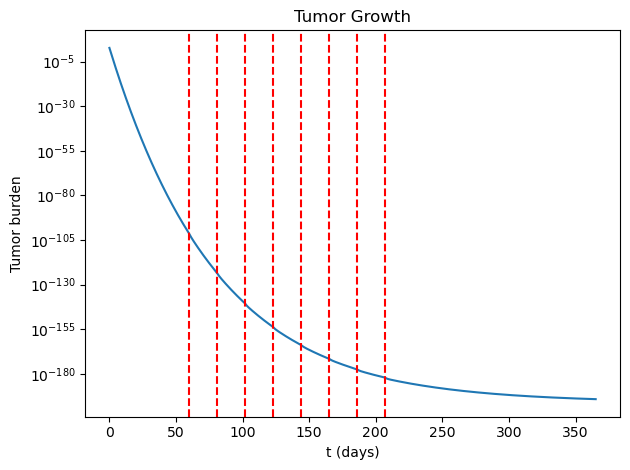

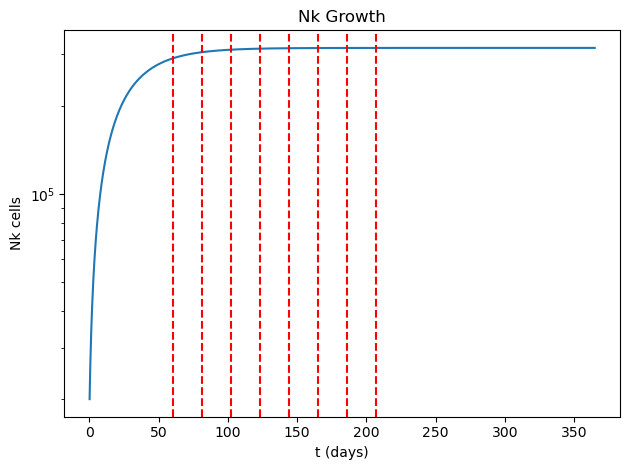

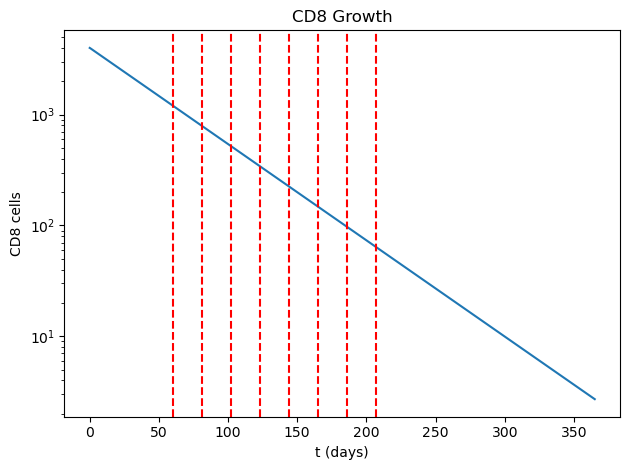

In [62]:
"""Model a small cancer and see if immune response squashes it"""

##########
# Choose model parameters
##########

# the time domain and initial guess
y0 = np.array([4.64e2, 2e4, 4e3]) # Tumor burden, Nk cells, CD8 cells

#############
# solve the system
#############
sol = solve_ivp(breast_cancer_ode, t_span, y0, args=[a, T_max, mu, gamma, alpha, d, s, lam, sigma, f, g, h, p, m, j, k, q, r, chemo_days], max_step=0.8)

plot_cancer_immune(sol, chemo_days)